### Explanation
This code analyses time lapse images of plates with growing colonies and gets their size and mean fluorescence over time together with some valuable characterization of their dynamics. It uses the python module FluoPi to perform these tasks.

##### Requirements
 - All images have to be same size
 - Have _fluopi_ module installed (open Terminal in Mac or command line in Windows and type  `pip install fluopi`; more info [here](https://packaging.python.org/tutorials/installing-packages/) about installing python packages)


## Analysis

### Loading packages
As part of the [FluoPi](https://osf.io/dy6p2/) project we provide a python module to manage and analyse time lapse data. We will also use some common modules for plotting and analysing data:

In [1]:
# Import the FluoPi module
from fluopi import plotting as flup
from fluopi import analysis as flua
# import some useful packages to manage the data

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path

#modify some matplotlib parameters to manage the images for illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading Data

In this section you have to include the path of the data to be used. Be careful because it asumes you have the images in a subfolder in the same path as this notebook. If you have the images in another external folder you have to include the full path direction (e.g. _'C/myuser/.../my_images_folder'_)

If you downloaded all the github repository you should have the images in the subfolder _'Images/'_ and then the path should be up and ready.

Also, the example data can be obtained from the **_Files_** section in the [OSF FluoPi proyect](https://osf.io/dy6p2/). There you can download it from the *Google drive/Example_data/Size_and_fluo* folder. Also, there you can found  other image series of your intertest.

After specifying the folder name where the images are stored, we are able to count the files:

In [42]:
fpath = os.path.abspath('Fotos Norm-N10')
print(fpath)
#imCount = flua.count_files(fpath, 'jpg')
imCount = 1

# save the last image number name
#lim=int(os.listdir(fpath)[-1].split('_')[-1].split('.')[0])
lim = 0

/Users/jorgeriverosvergara/Desktop/Universidad/10ºSemestre/Biologia Sintetica y Prototipado de Funciones Artificiales/Proyecto/biosync/Fotos Norm-N10


The _fluopi_ module provides a function to read images and save their values in 3-dimensional arrays (one for each channel). Now we can use this function to read and store the data of the images on a defined array for each channel:

In [12]:
import os
fname = os.path.join(fpath, 'LBkan_30uL_TLT2_10-11-17-14%02d.jpg')

Frames = 1
#Frames=12   # use one image every 12 frames, uncomment if you use the original data

DataS={}
DataS['R'],DataS['G'],DataS['B'] = flua.get_im_data(Frames,imCount,fname)
DataS['Im']=fname     # to store the related image source

# also define a vector with the channels
channels=['R','G','B']

Finally is important know the time step value used on the timelapse. It can be known from the python timelapse hardware control code stored on the folder (named 'interval' in the code).

In [13]:
#define it in hour units
dT=1.0  # hours, in this example interval = 1 hour for each frame

#dT= 1.0/12.0  # hours, uncomment if you use the original paper data where interval = 5 min for each frame


With this, we can construct a **time vector** 'T' for *DataS*

In [14]:

w,h,st=DataS['R'].shape
T=np.zeros((st))
for i in range(0,st):
    T[i]=(i)*Frames*dT

print(T)

[ 0.]


### Data management

#### Background computation and substraction

To take the valuable data of images is good to know the amount of background we have on it, if it changes over time or how noisy is it.

By ploting a transect of pixel values for each channel on an image, we can figure the efect of background: 

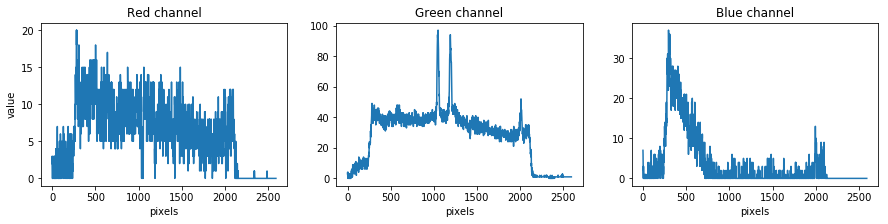

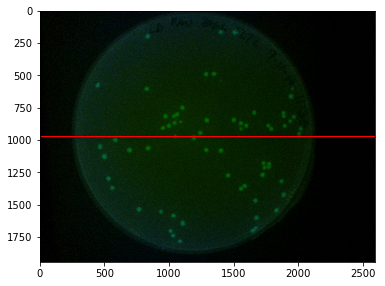

In [15]:



flup.row_transect(DataS, row=int(w/2), x_frames=Frames)

As you can see, data shows "peaks" (colonies) and a basal value along the line (background signal)

Then, to distinguish cell fluorescence from media and background light, we can select some empty sector on the image (i.e. without colonies) and compute his mean value on each frame.

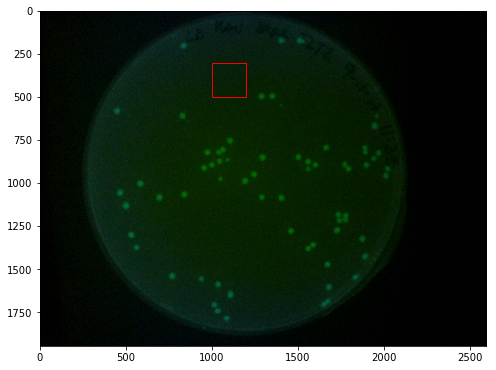

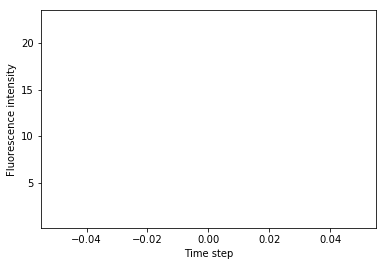

In [27]:
BG = flua.bg_value(300, 500, 1000, 1200, DataS, imCount)

We can substract this background value from each frame using BG_subst:

In [28]:
DataSB = flua.bg_subst(DataS,BG)

and we can check the effect on the background

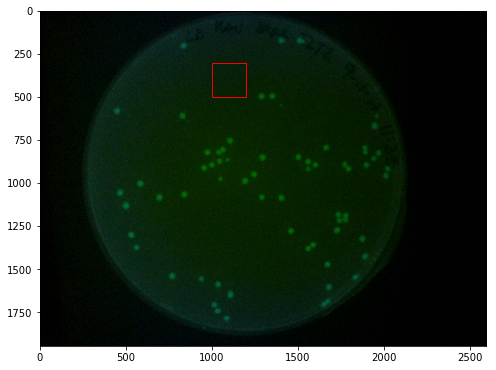

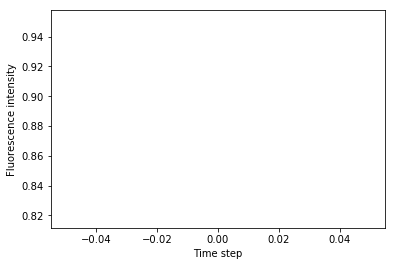

In [29]:
_ = flua.bg_value(300, 500, 1000, 1200, DataSB, imCount)

Background was practically eliminated.

### Get colony position
Here we are interested on identify the place where colonies are situated

A good way to do it is by sum the value of each pixel for all the channels and all the frames

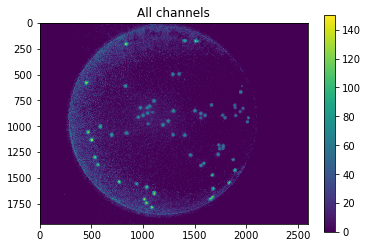

In [30]:
SumData = flua.data_sum_time(DataSB)

Now we can see each colony as a more clear point

#### Filter application
To improve the border detection and reduce the noise is recommended  to apply a filter to smooth the data. A simple and effective gaussian filter is provided by skimage package:
[skimage gaussian filter](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian)

In [31]:
from skimage.filters import gaussian

The effect of the filter can be understood with the next example:

In [32]:
#see the effect of the filter
a = np.zeros((3, 3))
a[1,1]=1
print('original: \n\n',a)
print('\nfiltered:')
gaussian(a, sigma=1)

original: 

 [[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]

filtered:


array([[ 0.05855018,  0.09653293,  0.05855018],
       [ 0.09653293,  0.15915589,  0.09653293],
       [ 0.05855018,  0.09653293,  0.05855018]])

Then we apply a the filter to the data (re-run the next line with different sigma values until you agree the smooth):

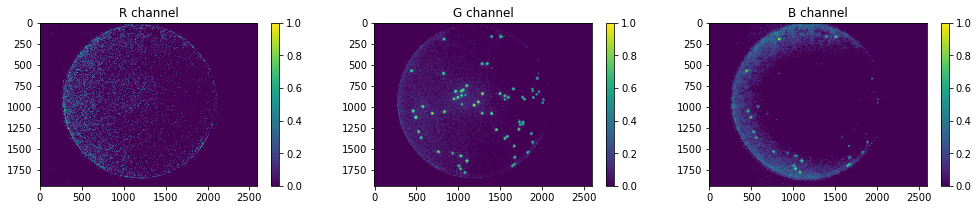

In [33]:
sDatS,sDatSall,sDatST=flua.smooth_data(DataSB,sigma=0.3)

And we can see the plot of the sumarized result

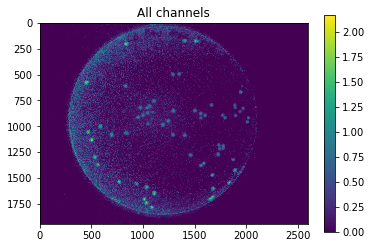

In [34]:
plt.imshow(sDatSall)
plt.colorbar()
plt.title('All channels')

#### Blob detection
Scikit-image provides several functions to detect Gaussian-like features ([blobs](http://scikit-image.org/docs/dev/auto_examples/plot_blob.html)). We apply one of these ([blob_log](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log)) to the smoothed sum of intensity, and it returns a list of position (x,y) and width (standard deviation):

To properly identification, it's important to set the threshold for each dataset manually (based on the previous colormap)

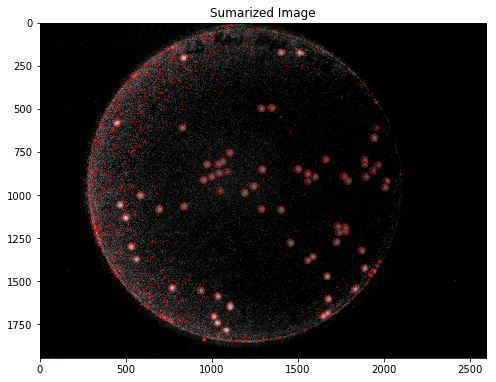

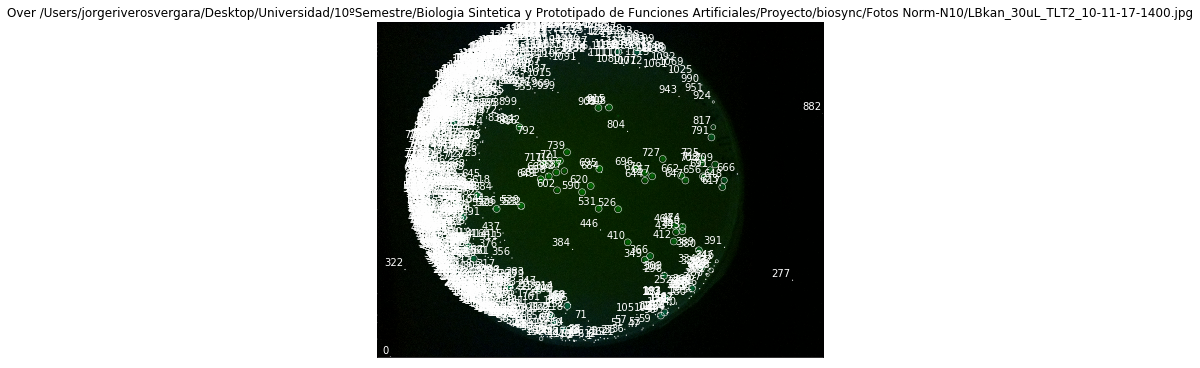

In [43]:
blobD = flua.colony_blobs_id(sDatSall,0.26,fname%(lim),filename='DetectedBlobs')

In [44]:
print(blobD[0])

[  1.94300000e+03   7.70000000e+01   1.36363636e+00]


/Users/jorgeriverosvergara/anaconda/envs/fluopi/lib/python3.6/site-packages/matplotlib/pyplot.py:3315: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)
/Users/jorgeriverosvergara/anaconda/envs/fluopi/lib/python3.6/site-packages/matplotlib/pyplot.py:3150: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


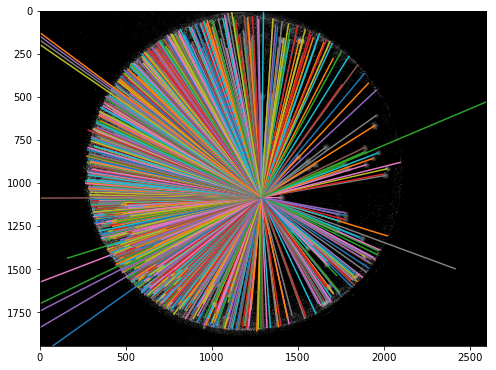

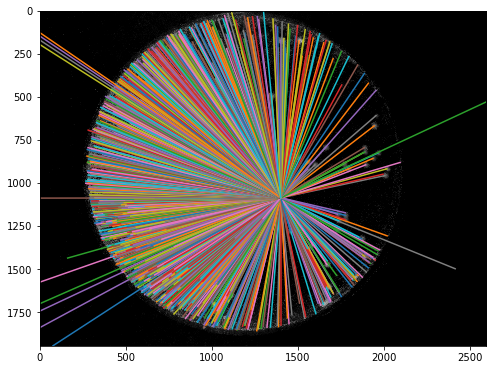

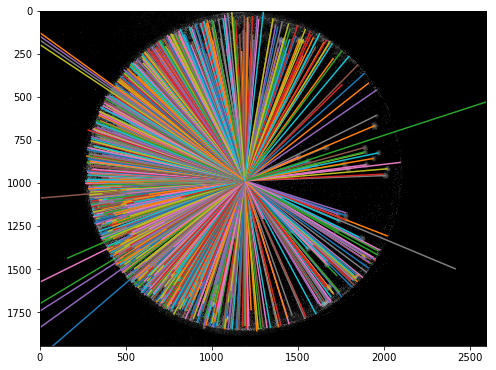

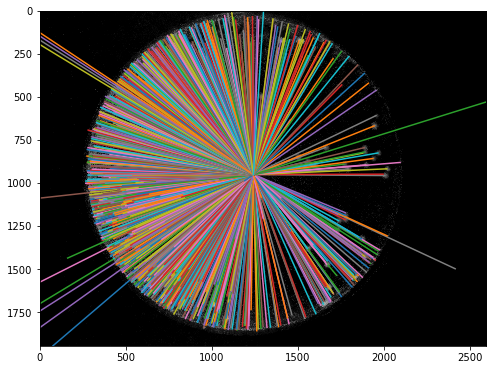

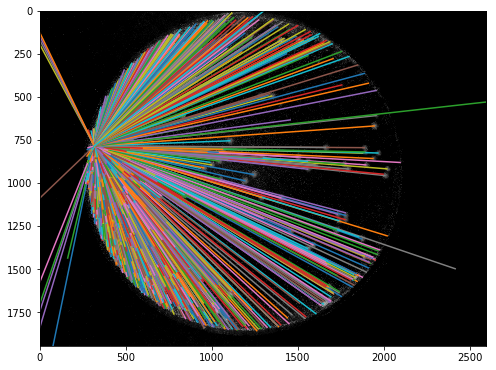

[1184.5674315968677, 1428.488011850292, 1351.9855768461437, 1347.3425696533156, 1318.3148334142343, 1354.3780860601667, 1387.0291994042518, 1346.810305870875, 1425.5683077285353, 1329.6029482518456, 1344.0037202329463, 1303.9497689711825, 1434.0746145162741, 1377.2937232123002, 1101.5961147353416, 1229.6479170884647, 1452.8275878437883, 1316.8021871184753, 1294.8857092423254, 1465.9757842474753, 1259.7285421867682, 1497.7189322432964, 1288.1401321284886, 1354.9202928585873, 1252.8180234974272, 1432.6747711884927, 1375.6663839754171, 1487.1196992844928, 1359.2486895340382, 1260.6355539964752, 1238.5160475343064, 1225.3587229868647, 1355.7883315621211, 1499.3892089781091, 1217.8723249996283, 1277.0, 1530.3346039347082, 1353.6617007214172, 1232.8231827800773, 1184.0979689198018, 1184.4002701789627, 1234.3127642538579, 1245.4918707081151, 1153.3195567577964, 1154.374722522977, 1148.8463778939288, 1133.0688416861528, 1578.8736491562586, 1154.3942134297106, 1197.0647434453995, 1258.263088547

In [46]:
def distanceBLOB(blobs,central): #inserta blobD e indice de el blob a investigar (lo ultimo le da flexibilidad para el futuro)
    distcenter = np.sqrt(((blobs[0]-central[0])**2)+((blobs[1]-central[1])**2))
    plt.plot([central[1],blobs[1]],[central[0],blobs[0]],hold = True)
    return distcenter

for c in [531,526,590,620,729]:
    distcen = []
    plt.figure(figsize=(8,8))
    for element in blobD:
        distcen.append(distanceBLOB(element,blobD[c])) #2 por ejemplo
    plt.imshow(sDatSall, cmap='gray',hold = True)
    plt.show()

print(distcen)

With the previous procedure we have identified where each colony is placed

To perform further analysis on each colony it is necesary to store these regions of interest (ROI) and his data, with size given by the Gaussian width (x2 = 2 standard deviations).

In [47]:
Rois,RoisC,NC = flua.obtain_rois(sDatST,blobD)

ROI x1 x2 y1 y2
0 1940 1943 74 81
ROI x1 x2 y1 y2
1 1854 1859 1258 1263
ROI x1 x2 y1 y2
2 1849 1854 1144 1149
ROI x1 x2 y1 y2
3 1847 1852 1139 1144
ROI x1 x2 y1 y2
4 1846 1851 1092 1097
ROI x1 x2 y1 y2
5 1845 1850 1153 1158
ROI x1 x2 y1 y2
6 1844 1849 1206 1211
ROI x1 x2 y1 y2
7 1844 1849 1142 1147
ROI x1 x2 y1 y2
8 1842 1849 1265 1272
ROI x1 x2 y1 y2
9 1842 1849 1114 1121
ROI x1 x2 y1 y2
10 1842 1847 1140 1145
ROI x1 x2 y1 y2
11 1842 1847 1073 1078
ROI x1 x2 y1 y2
12 1839 1846 1281 1288
ROI x1 x2 y1 y2
13 1838 1843 1198 1203
ROI x1 x2 y1 y2
14 1836 1841 0 3
ROI x1 x2 y1 y2
15 1825 1848 941 964
ROI x1 x2 y1 y2
16 1832 1839 1316 1323
ROI x1 x2 y1 y2
17 1832 1839 1106 1113
ROI x1 x2 y1 y2
18 1833 1838 1070 1075
ROI x1 x2 y1 y2
19 1832 1837 1337 1342
ROI x1 x2 y1 y2
20 1831 1836 1011 1016
ROI x1 x2 y1 y2
21 1830 1835 1384 1389
ROI x1 x2 y1 y2
22 1829 1834 1064 1069
ROI x1 x2 y1 y2
23 1828 1833 1175 1180
ROI x1 x2 y1 y2
24 1828 1833 1003 1008
ROI x1 x2 y1 y2
25 1827 1832 1294 1299
ROI x1 x

ROI x1 x2 y1 y2
261 1520 1525 778 783
ROI x1 x2 y1 y2
262 1518 1523 786 791
ROI x1 x2 y1 y2
263 1517 1522 768 773
ROI x1 x2 y1 y2
264 1515 1520 543 548
ROI x1 x2 y1 y2
265 1514 1519 568 573
ROI x1 x2 y1 y2
266 1514 1519 479 484
ROI x1 x2 y1 y2
267 1513 1518 1894 1899
ROI x1 x2 y1 y2
268 1511 1516 683 688
ROI x1 x2 y1 y2
269 1510 1515 794 799
ROI x1 x2 y1 y2
270 1510 1515 539 544
ROI x1 x2 y1 y2
271 1510 1515 490 495
ROI x1 x2 y1 y2
272 1508 1513 499 504
ROI x1 x2 y1 y2
273 1506 1511 632 637
ROI x1 x2 y1 y2
274 1503 1510 473 480
ROI x1 x2 y1 y2
275 1497 1502 825 830
ROI x1 x2 y1 y2
276 1496 1501 781 786
ROI x1 x2 y1 y2
277 1494 1499 2410 2415
ROI x1 x2 y1 y2
278 1494 1499 550 555
ROI x1 x2 y1 y2
279 1493 1498 865 870
ROI x1 x2 y1 y2
280 1489 1494 1906 1911
ROI x1 x2 y1 y2
281 1488 1493 573 578
ROI x1 x2 y1 y2
282 1488 1493 468 473
ROI x1 x2 y1 y2
283 1485 1490 863 868
ROI x1 x2 y1 y2
284 1485 1490 578 583
ROI x1 x2 y1 y2
285 1483 1488 462 467
ROI x1 x2 y1 y2
286 1482 1487 684 689
ROI x1

538 1065 1070 289 294
ROI x1 x2 y1 y2
539 1045 1086 817 858
ROI x1 x2 y1 y2
540 1062 1067 564 569
ROI x1 x2 y1 y2
541 1061 1066 636 641
ROI x1 x2 y1 y2
542 1061 1066 499 504
ROI x1 x2 y1 y2
543 1059 1064 503 508
ROI x1 x2 y1 y2
544 1059 1064 493 498
ROI x1 x2 y1 y2
545 1059 1064 367 372
ROI x1 x2 y1 y2
546 1054 1059 506 511
ROI x1 x2 y1 y2
547 1036 1077 446 487
ROI x1 x2 y1 y2
548 1048 1055 294 301
ROI x1 x2 y1 y2
549 1043 1048 481 486
ROI x1 x2 y1 y2
550 1041 1046 489 494
ROI x1 x2 y1 y2
551 1039 1044 475 480
ROI x1 x2 y1 y2
552 1039 1044 327 332
ROI x1 x2 y1 y2
553 1039 1044 310 315
ROI x1 x2 y1 y2
554 1039 1044 297 302
ROI x1 x2 y1 y2
555 1037 1042 451 456
ROI x1 x2 y1 y2
556 1036 1041 504 509
ROI x1 x2 y1 y2
557 1036 1041 287 292
ROI x1 x2 y1 y2
558 1033 1038 471 476
ROI x1 x2 y1 y2
559 1033 1038 319 324
ROI x1 x2 y1 y2
560 1030 1035 326 331
ROI x1 x2 y1 y2
561 1029 1034 283 288
ROI x1 x2 y1 y2
562 1021 1026 577 582
ROI x1 x2 y1 y2
563 1021 1026 411 416
ROI x1 x2 y1 y2
564 1021 102

ROI x1 x2 y1 y2
807 620 625 594 599
ROI x1 x2 y1 y2
808 619 624 429 434
ROI x1 x2 y1 y2
809 619 624 421 426
ROI x1 x2 y1 y2
810 618 623 363 368
ROI x1 x2 y1 y2
811 615 620 541 546
ROI x1 x2 y1 y2
812 611 616 419 424
ROI x1 x2 y1 y2
813 610 615 496 501
ROI x1 x2 y1 y2
814 609 614 627 632
ROI x1 x2 y1 y2
815 609 614 582 587
ROI x1 x2 y1 y2
816 588 629 807 848
ROI x1 x2 y1 y2
817 593 622 1938 1967
ROI x1 x2 y1 y2
818 605 610 377 382
ROI x1 x2 y1 y2
819 604 609 588 593
ROI x1 x2 y1 y2
820 604 609 361 366
ROI x1 x2 y1 y2
821 604 609 342 347
ROI x1 x2 y1 y2
822 602 607 842 847
ROI x1 x2 y1 y2
823 598 603 350 355
ROI x1 x2 y1 y2
824 597 602 807 812
ROI x1 x2 y1 y2
825 596 601 443 448
ROI x1 x2 y1 y2
826 596 601 348 353
ROI x1 x2 y1 y2
827 595 600 581 586
ROI x1 x2 y1 y2
828 593 598 454 459
ROI x1 x2 y1 y2
829 593 598 427 432
ROI x1 x2 y1 y2
830 591 596 429 434
ROI x1 x2 y1 y2
831 589 594 758 763
ROI x1 x2 y1 y2
832 588 593 457 462
ROI x1 x2 y1 y2
833 587 592 548 553
ROI x1 x2 y1 y2
834 587 59

1044 295 300 613 618
ROI x1 x2 y1 y2
1045 281 314 542 575
ROI x1 x2 y1 y2
1046 294 299 638 643
ROI x1 x2 y1 y2
1047 293 298 735 740
ROI x1 x2 y1 y2
1048 293 298 699 704
ROI x1 x2 y1 y2
1049 290 295 634 639
ROI x1 x2 y1 y2
1050 289 294 874 879
ROI x1 x2 y1 y2
1051 285 290 611 616
ROI x1 x2 y1 y2
1052 283 290 604 611
ROI x1 x2 y1 y2
1053 283 288 800 805
ROI x1 x2 y1 y2
1054 283 288 566 571
ROI x1 x2 y1 y2
1055 280 285 766 771
ROI x1 x2 y1 y2
1056 280 285 598 603
ROI x1 x2 y1 y2
1057 279 284 679 684
ROI x1 x2 y1 y2
1058 277 282 908 913
ROI x1 x2 y1 y2
1059 276 281 699 704
ROI x1 x2 y1 y2
1060 275 280 903 908
ROI x1 x2 y1 y2
1061 274 279 1701 1706
ROI x1 x2 y1 y2
1062 271 276 671 676
ROI x1 x2 y1 y2
1063 267 272 714 719
ROI x1 x2 y1 y2
1064 266 271 635 640
ROI x1 x2 y1 y2
1065 265 270 850 855
ROI x1 x2 y1 y2
1066 264 269 690 695
ROI x1 x2 y1 y2
1067 263 268 965 970
ROI x1 x2 y1 y2
1068 263 268 594 599
ROI x1 x2 y1 y2
1069 262 267 1792 1797
ROI x1 x2 y1 y2
1070 262 267 848 853
ROI x1 x2 y1 

76 1725 1730 1039 1044
ROI x1 x2 y1 y2
77 1725 1730 804 809
ROI x1 x2 y1 y2
78 1724 1729 812 817
ROI x1 x2 y1 y2
79 1723 1728 765 770
ROI x1 x2 y1 y2
80 1723 1728 721 726
ROI x1 x2 y1 y2
81 1722 1727 736 741
ROI x1 x2 y1 y2
82 1721 1726 731 736
ROI x1 x2 y1 y2
83 1721 1726 717 722
ROI x1 x2 y1 y2
84 1720 1725 744 749
ROI x1 x2 y1 y2
85 1717 1722 835 840
ROI x1 x2 y1 y2
86 1713 1718 915 920
ROI x1 x2 y1 y2
87 1712 1717 807 812
ROI x1 x2 y1 y2
88 1711 1718 739 746
ROI x1 x2 y1 y2
89 1710 1715 831 836
ROI x1 x2 y1 y2
90 1708 1713 783 788
ROI x1 x2 y1 y2
91 1708 1713 739 744
ROI x1 x2 y1 y2
92 1697 1724 711 738
ROI x1 x2 y1 y2
93 1707 1712 795 800
ROI x1 x2 y1 y2
94 1707 1712 692 697
ROI x1 x2 y1 y2
95 1706 1711 696 701
ROI x1 x2 y1 y2
96 1705 1710 1629 1634
ROI x1 x2 y1 y2
97 1702 1707 862 867
ROI x1 x2 y1 y2
98 1682 1723 989 1030
ROI x1 x2 y1 y2
99 1681 1722 1627 1668
ROI x1 x2 y1 y2
100 1699 1704 805 810
ROI x1 x2 y1 y2
101 1698 1703 805 810
ROI x1 x2 y1 y2
102 1696 1703 0 4
ROI x1 x2 y

ROI x1 x2 y1 y2
358 1363 1368 493 498
ROI x1 x2 y1 y2
359 1363 1368 395 400
ROI x1 x2 y1 y2
360 1362 1367 643 648
ROI x1 x2 y1 y2
361 1361 1366 663 668
ROI x1 x2 y1 y2
362 1359 1364 419 424
ROI x1 x2 y1 y2
363 1357 1362 526 531
ROI x1 x2 y1 y2
364 1355 1360 543 548
ROI x1 x2 y1 y2
365 1355 1360 434 439
ROI x1 x2 y1 y2
366 1336 1377 1565 1606
ROI x1 x2 y1 y2
367 1354 1359 626 631
ROI x1 x2 y1 y2
368 1352 1357 470 475
ROI x1 x2 y1 y2
369 1352 1357 436 441
ROI x1 x2 y1 y2
370 1332 1337 469 474
ROI x1 x2 y1 y2
371 1330 1335 496 501
ROI x1 x2 y1 y2
372 1330 1335 379 384
ROI x1 x2 y1 y2
373 1328 1333 361 366
ROI x1 x2 y1 y2
374 1327 1332 469 474
ROI x1 x2 y1 y2
375 1325 1330 366 371
ROI x1 x2 y1 y2
376 1323 1328 707 712
ROI x1 x2 y1 y2
377 1322 1327 390 395
ROI x1 x2 y1 y2
378 1321 1326 377 382
ROI x1 x2 y1 y2
379 1320 1327 361 368
ROI x1 x2 y1 y2
380 1302 1343 1848 1889
ROI x1 x2 y1 y2
381 1319 1324 428 433
ROI x1 x2 y1 y2
382 1318 1323 380 385
ROI x1 x2 y1 y2
383 1316 1321 522 527
ROI x1 x

629 937 942 443 448
ROI x1 x2 y1 y2
630 937 942 351 356
ROI x1 x2 y1 y2
631 937 942 301 306
ROI x1 x2 y1 y2
632 936 941 471 476
ROI x1 x2 y1 y2
633 936 941 369 374
ROI x1 x2 y1 y2
634 935 940 525 530
ROI x1 x2 y1 y2
635 931 940 276 285
ROI x1 x2 y1 y2
636 932 937 276 281
ROI x1 x2 y1 y2
637 929 934 309 314
ROI x1 x2 y1 y2
638 926 931 482 487
ROI x1 x2 y1 y2
639 926 931 300 305
ROI x1 x2 y1 y2
640 925 930 277 282
ROI x1 x2 y1 y2
641 921 926 482 487
ROI x1 x2 y1 y2
642 921 926 394 399
ROI x1 x2 y1 y2
643 921 926 295 300
ROI x1 x2 y1 y2
644 899 938 1536 1575
ROI x1 x2 y1 y2
645 916 921 610 615
ROI x1 x2 y1 y2
646 916 921 304 309
ROI x1 x2 y1 y2
647 897 938 1770 1811
ROI x1 x2 y1 y2
648 898 935 1997 2034
ROI x1 x2 y1 y2
649 911 916 930 935
ROI x1 x2 y1 y2
650 911 916 408 413
ROI x1 x2 y1 y2
651 890 931 930 971
ROI x1 x2 y1 y2
652 898 903 309 314
ROI x1 x2 y1 y2
653 898 903 300 305
ROI x1 x2 y1 y2
654 896 901 319 324
ROI x1 x2 y1 y2
655 896 901 302 307
ROI x1 x2 y1 y2
656 873 914 1872 1913


ROI x1 x2 y1 y2
944 427 432 541 546
ROI x1 x2 y1 y2
945 426 431 752 757
ROI x1 x2 y1 y2
946 424 429 582 587
ROI x1 x2 y1 y2
947 423 428 542 547
ROI x1 x2 y1 y2
948 422 427 612 617
ROI x1 x2 y1 y2
949 422 427 606 611
ROI x1 x2 y1 y2
950 419 424 437 442
ROI x1 x2 y1 y2
951 417 422 1906 1911
ROI x1 x2 y1 y2
952 414 419 508 513
ROI x1 x2 y1 y2
953 409 414 453 458
ROI x1 x2 y1 y2
954 407 412 607 612
ROI x1 x2 y1 y2
955 406 411 914 919
ROI x1 x2 y1 y2
956 406 411 702 707
ROI x1 x2 y1 y2
957 405 410 615 620
ROI x1 x2 y1 y2
958 405 410 453 458
ROI x1 x2 y1 y2
959 404 409 1048 1053
ROI x1 x2 y1 y2
960 404 409 518 523
ROI x1 x2 y1 y2
961 403 408 463 468
ROI x1 x2 y1 y2
962 400 405 708 713
ROI x1 x2 y1 y2
963 399 404 535 540
ROI x1 x2 y1 y2
964 398 403 688 693
ROI x1 x2 y1 y2
965 398 403 684 689
ROI x1 x2 y1 y2
966 394 399 648 653
ROI x1 x2 y1 y2
967 393 398 540 545
ROI x1 x2 y1 y2
968 393 398 464 469
ROI x1 x2 y1 y2
969 392 397 1017 1022
ROI x1 x2 y1 y2
970 392 397 729 734
ROI x1 x2 y1 y2
971 39

ROI x1 x2 y1 y2
1173 152 157 786 791
ROI x1 x2 y1 y2
1174 150 155 773 778
ROI x1 x2 y1 y2
1175 149 154 777 782
ROI x1 x2 y1 y2
1176 148 153 832 837
ROI x1 x2 y1 y2
1177 148 153 764 769
ROI x1 x2 y1 y2
1178 148 153 751 756
ROI x1 x2 y1 y2
1179 146 151 1615 1620
ROI x1 x2 y1 y2
1180 145 150 1483 1488
ROI x1 x2 y1 y2
1181 144 149 806 811
ROI x1 x2 y1 y2
1182 144 149 776 781
ROI x1 x2 y1 y2
1183 143 148 1007 1012
ROI x1 x2 y1 y2
1184 142 149 0 4
ROI x1 x2 y1 y2
1185 142 147 824 829
ROI x1 x2 y1 y2
1186 141 146 740 745
ROI x1 x2 y1 y2
1187 140 145 1234 1239
ROI x1 x2 y1 y2
1188 128 155 757 784
ROI x1 x2 y1 y2
1189 138 143 837 842
ROI x1 x2 y1 y2
1190 137 142 843 848
ROI x1 x2 y1 y2
1191 137 142 809 814
ROI x1 x2 y1 y2
1192 137 142 795 800
ROI x1 x2 y1 y2
1193 136 141 1573 1578
ROI x1 x2 y1 y2
1194 136 141 1083 1088
ROI x1 x2 y1 y2
1195 135 140 1159 1164
ROI x1 x2 y1 y2
1196 133 138 807 812
ROI x1 x2 y1 y2
1197 133 138 785 790
ROI x1 x2 y1 y2
1198 133 138 760 765
ROI x1 x2 y1 y2
1199 129 134

190 1593 1598 557 562
ROI x1 x2 y1 y2
191 1592 1597 623 628
ROI x1 x2 y1 y2
192 1592 1597 578 583
ROI x1 x2 y1 y2
193 1591 1596 1661 1666
ROI x1 x2 y1 y2
194 1591 1596 628 633
ROI x1 x2 y1 y2
195 1588 1593 1822 1827
ROI x1 x2 y1 y2
196 1587 1592 655 660
ROI x1 x2 y1 y2
197 1587 1592 645 650
ROI x1 x2 y1 y2
198 1585 1590 779 784
ROI x1 x2 y1 y2
199 1585 1590 651 656
ROI x1 x2 y1 y2
200 1566 1607 1013 1054
ROI x1 x2 y1 y2
201 1583 1590 649 656
ROI x1 x2 y1 y2
202 1584 1589 548 553
ROI x1 x2 y1 y2
203 1583 1588 649 654
ROI x1 x2 y1 y2
204 1582 1587 1012 1017
ROI x1 x2 y1 y2
205 1578 1583 651 656
ROI x1 x2 y1 y2
206 1572 1577 0 3
ROI x1 x2 y1 y2
207 1571 1576 531 536
ROI x1 x2 y1 y2
208 1570 1575 712 717
ROI x1 x2 y1 y2
209 1569 1574 533 538
ROI x1 x2 y1 y2
210 1568 1573 604 609
ROI x1 x2 y1 y2
211 1567 1572 1840 1845
ROI x1 x2 y1 y2
212 1567 1572 1033 1038
ROI x1 x2 y1 y2
213 1567 1572 945 950
ROI x1 x2 y1 y2
214 1565 1570 1031 1036
ROI x1 x2 y1 y2
215 1565 1570 919 924
ROI x1 x2 y1 y2
21

454 1193 1198 455 460
ROI x1 x2 y1 y2
455 1193 1198 341 346
ROI x1 x2 y1 y2
456 1192 1197 310 315
ROI x1 x2 y1 y2
457 1189 1194 338 343
ROI x1 x2 y1 y2
458 1188 1193 526 531
ROI x1 x2 y1 y2
459 1174 1201 305 332
ROI x1 x2 y1 y2
460 1166 1207 1753 1794
ROI x1 x2 y1 y2
461 1182 1187 437 442
ROI x1 x2 y1 y2
462 1182 1187 380 385
ROI x1 x2 y1 y2
463 1179 1184 398 403
ROI x1 x2 y1 y2
464 1159 1200 1708 1749
ROI x1 x2 y1 y2
465 1174 1181 395 402
ROI x1 x2 y1 y2
466 1175 1180 331 336
ROI x1 x2 y1 y2
467 1174 1179 373 378
ROI x1 x2 y1 y2
468 1173 1178 483 488
ROI x1 x2 y1 y2
469 1172 1177 426 431
ROI x1 x2 y1 y2
470 1172 1177 299 304
ROI x1 x2 y1 y2
471 1171 1176 433 438
ROI x1 x2 y1 y2
472 1171 1176 371 376
ROI x1 x2 y1 y2
473 1170 1175 317 322
ROI x1 x2 y1 y2
474 1169 1174 1773 1778
ROI x1 x2 y1 y2
475 1169 1174 311 316
ROI x1 x2 y1 y2
476 1167 1172 511 516
ROI x1 x2 y1 y2
477 1167 1172 315 320
ROI x1 x2 y1 y2
478 1164 1169 311 316
ROI x1 x2 y1 y2
479 1135 1168 292 325
ROI x1 x2 y1 y2
480 11

791 647 688 1921 1962
ROI x1 x2 y1 y2
792 663 668 926 931
ROI x1 x2 y1 y2
793 660 665 410 415
ROI x1 x2 y1 y2
794 658 663 444 449
ROI x1 x2 y1 y2
795 653 658 333 338
ROI x1 x2 y1 y2
796 651 656 524 529
ROI x1 x2 y1 y2
797 651 656 335 340
ROI x1 x2 y1 y2
798 647 652 427 432
ROI x1 x2 y1 y2
799 646 651 328 333
ROI x1 x2 y1 y2
800 645 650 377 382
ROI x1 x2 y1 y2
801 636 641 351 356
ROI x1 x2 y1 y2
802 634 639 332 337
ROI x1 x2 y1 y2
803 632 637 433 438
ROI x1 x2 y1 y2
804 630 635 1452 1457
ROI x1 x2 y1 y2
805 628 633 410 415
ROI x1 x2 y1 y2
806 626 631 416 421
ROI x1 x2 y1 y2
807 620 625 594 599
ROI x1 x2 y1 y2
808 619 624 429 434
ROI x1 x2 y1 y2
809 619 624 421 426
ROI x1 x2 y1 y2
810 618 623 363 368
ROI x1 x2 y1 y2
811 615 620 541 546
ROI x1 x2 y1 y2
812 611 616 419 424
ROI x1 x2 y1 y2
813 610 615 496 501
ROI x1 x2 y1 y2
814 609 614 627 632
ROI x1 x2 y1 y2
815 609 614 582 587
ROI x1 x2 y1 y2
816 588 629 807 848
ROI x1 x2 y1 y2
817 593 622 1938 1967
ROI x1 x2 y1 y2
818 605 610 377 382
RO

ROI x1 x2 y1 y2
1092 233 238 1749 1754
ROI x1 x2 y1 y2
1093 232 237 649 654
ROI x1 x2 y1 y2
1094 230 235 767 772
ROI x1 x2 y1 y2
1095 229 234 918 923
ROI x1 x2 y1 y2
1096 229 234 633 638
ROI x1 x2 y1 y2
1097 228 233 786 791
ROI x1 x2 y1 y2
1098 227 232 748 753
ROI x1 x2 y1 y2
1099 226 231 782 787
ROI x1 x2 y1 y2
1100 224 229 752 757
ROI x1 x2 y1 y2
1101 222 227 671 676
ROI x1 x2 y1 y2
1102 220 225 834 839
ROI x1 x2 y1 y2
1103 219 224 627 632
ROI x1 x2 y1 y2
1104 218 223 674 679
ROI x1 x2 y1 y2
1105 218 223 656 661
ROI x1 x2 y1 y2
1106 217 222 1083 1088
ROI x1 x2 y1 y2
1107 217 222 765 770
ROI x1 x2 y1 y2
1108 215 222 681 688
ROI x1 x2 y1 y2
1109 215 220 940 945
ROI x1 x2 y1 y2
1110 213 218 1425 1430
ROI x1 x2 y1 y2
1111 213 218 1383 1388
ROI x1 x2 y1 y2
1112 211 216 767 772
ROI x1 x2 y1 y2
1113 210 217 675 682
ROI x1 x2 y1 y2
1114 209 216 648 655
ROI x1 x2 y1 y2
1115 208 213 1598 1603
ROI x1 x2 y1 y2
1116 208 213 1003 1008
ROI x1 x2 y1 y2
1117 208 213 732 737
ROI x1 x2 y1 y2
1118 206 2

we can ilustrate the data with the first blob (colony)

# show the first column of the first ROI
print(Rois['R'][1][:,1,1])
print(RoisC['R'][1][:,1,1]) #it contains only the pixels inside the circular region, and make the other equal to zero

In [48]:
print(Rois['R'][14][:,1,1]) 
print(RoisC['R'][14][:,1,1])
#it contains only the pixels inside the circular region, and make the other equal to zero

IndexError: index 1 is out of bounds for axis 2 with size 1

The ROI let us to track every colony in a seperatelly way. The module includes a package to save an image of a selected ROI at selected times. Then is possible make timelapse grow of an indivial colony.

FileNotFoundError: [Errno 2] No such file or directory: 'ROIs/Col9_ROI_step25.png'

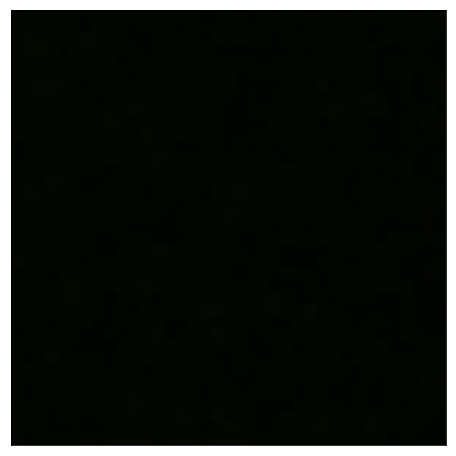

In [50]:
#Orange example
#idx=9
#fname=('ROIs/Col'+str(idx)+'_ROI_step%d.png')
#Times=[24,49,74,99,124,150]
#flup.tl_roi(Rois,idx,Times,fname,gridsize=[2,3])

In [ ]:
#Red example
#idx=8
#fname=('ROIs/Col'+str(idx)+'_ROI_step%d.png')
#Times=[24,49,74,99,124,150]

#flup.tl_roi(Rois,idx,Times,fname,gridsize=[2,3])

In [ ]:
#Green example
#idx=40
#fname=('ROIs/Col'+str(idx)+'_ROI_step%d.png')
#Times=[24,49,74,99,124,150]

#flup.tl_roi(Rois,idx,Times,fname,gridsize=[2,3])

### Time dynamics of colonies
As we have estimated colony location (and maximmum size), we can analyse the dynamics of fluorescence and growth of them. 

#### Fluorescence dynamics
With the data obtained so far we can plot the fluorescence dynamics of colonies. We can choose some representative colonies and use the FluoPi `rois_plt_fluo_dynam()` function to perform this task:

Each line correspond to a different ROI


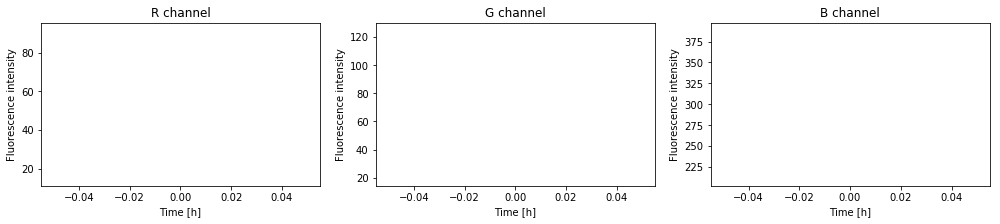

In [50]:
#define the selected colonies
Cols=[1,17,45,40,45,46,22,31,7]

#use the function to plot
#flup.rois_plt_fluo_dynam(RoisC,T,Cols)
flup.rois_plt_fluo_dynam(RoisC,T,Cols,filename='Channel_total_intensity')

print('Each line correspond to a different ROI')

#### Colony radius growth
We have the location and a final size estimate based on the total fluorescence of each colony over the time-lapse. We would like to know the size of the colony in each frame; from this we can compute the growth rate.

One way to do this is to find Gaussian blobs in each of the image regions of the colony, for each frame of the time-lapse.This is very slow

First we perform the sum of all channels for each frame to get the best representation of colony size:

In [51]:
ACRois=flua.channels_sum(RoisC,Cols) #circular ROIS

In [52]:
ACRoisS=flua.channels_sum(Rois,Cols) #square ROIS

The following loop finds blobs and stores the width in each frame. The result is a dict containing the size at each time point for every colony

In [53]:
import time
start = time.time()
R_frame=flua.frame_colony_radius(ACRoisS,Cols,0.37)
end = time.time()
print(str(end - start)+' seg') #to know how long it takes to run

0.3858621120452881 seg


Since the colony is roughly circular and flat, an estimate of volume is $R^2$. Lets plot this for some colonies. Plotting the log is useful because the slope is the relative growth rate. We can see the colonies slow their growth during the experiment.

Each line correspond to one colony


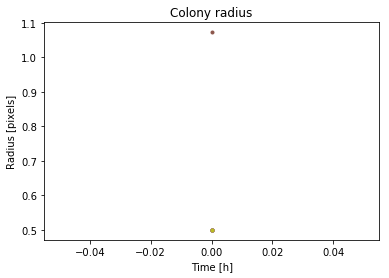

In [54]:
flup.plot_radius(R_frame, Cols, T)
print('Each line correspond to one colony')

#### Check the radius estimate
To see how well the colony size is estimated, we can compare to the profile of a colony in a slice of its image region. The radius (red line) should give the border of the colony.

/Users/jorgeriverosvergara/Desktop/Universidad/10ºSemestre/Biologia Sintetica y Prototipado de Funciones Artificiales/Jupyter/FluoPi/fluopi/plotting.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_dots != 'null':


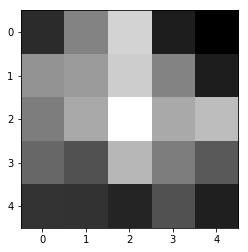

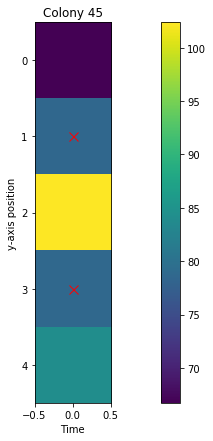

In [56]:
IDCol=Cols[2]
print()
plt.figure()
plt.imshow(ACRoisS[IDCol][:,:,-1], interpolation='none', cmap='gray')
#flup.check_radius(ACRoisS, IDCol, T, r_dots=R_frame[IDCol])
flup.check_radius(ACRoisS, IDCol, T, r_dots=R_frame[IDCol], filename='Kymograph_'+str(IDCol))


##### Getting the colony area over time $A(t)$
with the radius value we are able to get the colony area over time by taking it as a perfect circle: $$A(t) = \pi \cdot r^{2}$$

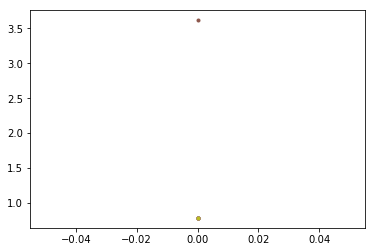

In [57]:
A=flua.area(R_frame,Cols,T)

To improve determination of radius we can fix a monotonically incresing function to the obstained values for each colony. This function could be of sigmodial type:
\begin{equation}
A(t) = \frac{a}{1+ e^{-d(t+b)}}
\end{equation}

where $a$ is the maximum area of the colony ($a = A_{max}$) and  $b$ is the time where the colony reach half of his maximum growth ($b = t_d$)

You can se the effect of the parameters evaluating the function F_logistic:

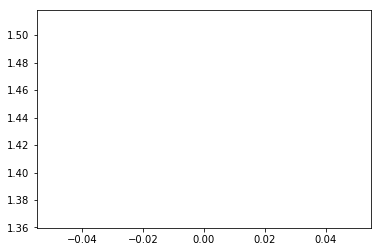

In [58]:
Sigmoid=flua.f_sigma(T, 80, -20, 0.2)
plt.plot(T,Sigmoid)

With the function `function_fit` you can fit a mathematical model (*F_sigma* by default) to one seleceted colony:

In [60]:
idx=Cols[2:3] # idx have to be an array, then to select one colony use this notation Cols[desired:desired+1]
init=20
end=-1
SingleF=flua.function_fit(T,A,init,end,idx)

ValueError: On entry to DGESDD parameter number 5 had an illegal value

or you can perform the fit to a dictionary of selected colonies with the same function:

In [61]:
init=21
end=-1
A_fitS=flua.function_fit(T,A,init,end,Cols)

ValueError: On entry to DGESDD parameter number 5 had an illegal value

We can put alltogheter on one plot:

In [61]:
#set the color vector to have concordance between dots and fitted curves
colors = plt.cm.jet(np.linspace(0, 1, len(Cols))) #Paired o jet #https://matplotlib.org/users/colormaps.html


FileNotFoundError: [Errno 2] No such file or directory: 'Plots/Size_and_fluo/AreaFit.pdf'

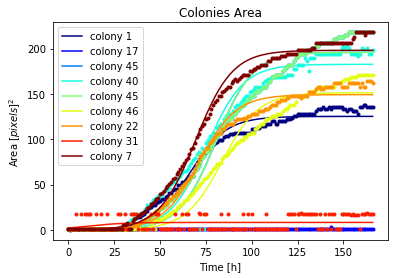

In [62]:
for i, c in zip(Cols, colors):
    plt.plot(T,A[i],'.',color=c)
    plt.plot(T,A_fitS[i][0],'-',color=c,label='colony '+str(i))

plt.xlabel('Time [h]')
plt.ylabel('Area $[pixels]^2$') 
plt.title('Colonies Area')
#plt.xlabel('Time [h]')
plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/AreaFit.pdf", transparent=True)

With the area function we are able to back-compute the radius: $$ r (t) = \sqrt{\frac{A(t)}{\pi}} $$

FileNotFoundError: [Errno 2] No such file or directory: 'Plots/Size_and_fluo/colonyRadiusFit.pdf'

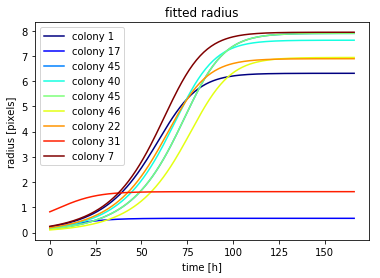

In [63]:
from math import pi
r_fit={}

plt.figure()
for i, c in zip(Cols, colors):
    r_fit[i]=(A_fitS[i][0]/pi)**(0.5)
    
    plt.plot(T,r_fit[i],'-',color=c,label='colony '+str(i))

plt.title('fitted radius')
plt.ylabel('radius [pixels]')
plt.xlabel('time [h]')
plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/colonyRadiusFit.pdf", transparent=True)

/Users/jorgeriverosvergara/anaconda/envs/fluopi/lib/python3.6/site-packages/matplotlib/pyplot.py:3315: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


KeyError: 0

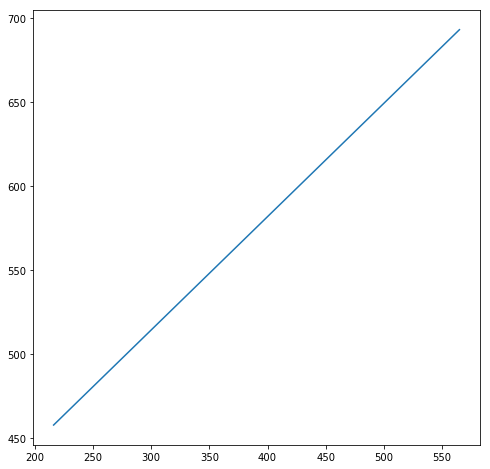

In [78]:
def distanceBLOB(blobs,central): #inserta blobD e indice de el blob a investigar (lo ultimo le da flexibilidad para el futuro)
    distcenter = np.sqrt(((blobs[0]-central[0])**2)+((blobs[1]-central[1])**2))
    plt.plot([central[1],blobs[1]],[central[0],blobs[0]],hold = True)
    return distcenter

#IMPORTANTE, ESTE CODIGO NO CONSIDERARA CADA UNA DE NUESTRAS IMAGENES COMO DISTINTAS, NUESTRO RADIO ES DISTINTO PARA
#CADA IMAGEN, NUESTRAS DISTANCIAS SON "DISTINTAS" PARA CADA IMAGEN Y ESO ES LO QUE CORRELACIONAMOS PARA CADA INTENTO
#DEL EXPERIMENTO, POR LO CUAL FLUOPI, QUE USA TIMELAPSES, PARA --LAS MISMAS PLACAS-- NO NOS SIRVE.

distcen = []
distrad = []
radius = r_fit
plt.figure(figsize=(8,8))
i = 0
aux1, aux2, aux3 = 0, 0, 0

for element in blobD:
    
    central = 12 #por ejemplo
    if i == central:
        continue
    distances = distanceBLOB(element,blobD[central])
    distrad.append([distances,radius[i], radius[central],len(blobD)]) #distrad es [distancia,radiosatelite,radiocentral,numerodeblobs] 
    avdist += distances/len(blobD)
    avrad +=radius[central]/len(blodD)
    i += 1
    
print(distrad)

for element in distrad:
    xi,xp = element[2],avdrad
    yi,yp = element[0],avdist
    aux1 += (xi-xp)*(yi-yp)
    aux2 += np.sqrt((xi-xp)**2)
    aux3 += np.sqrt((yi-yp)**2)
    
correlation = aux1/(aux2*aux3)
#aca tenemos una correlacion para 1 n, luego lo hacemos para multiples n y graficamos n versus correlacion, encon-
#trando como varia el crecimiento de las baterias dependiendo del numero de bacterias satelites
#Ademas si la curva es bonita, podemos modelarle una curva y asi predecir para cualquier n y aplicarlo a cualquier
#muestra y cualquier colonia centrar.

plt.imshow(sDatSall, cmap='gray',hold = True)
plt.show()
print(distcen)

We can plot it and the blob radius together:

In [ ]:
#fluopi.plot_radius(R_frame5,Cols,T)
for i, c in zip(Cols, colors):
    plt.plot(T,R_frame[i],'.',color=c)
    plt.plot(T,r_fit[i],'-',color=c,label='colony '+str(i))
plt.title('Radius')
plt.ylabel('radius [pixels]')
plt.xlabel('time [h]')
plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/colonyRadiusFit_points.pdf", transparent=True)

Now we can check the radius estimation again:

In [ ]:
IDCol=int(Cols[0])
#flup.check_radius(ACRoisS,IDCol,T,r_fit=r_fit[IDCol],r_dots=R_frame[IDCol])
flup.check_radius(ACRoisS,IDCol,T,r_fit=r_fit[IDCol],r_dots=R_frame[IDCol],filename='Plots/Size_and_fluo/3Kymograph_fit2_color_'+str(IDCol))

In [ ]:
IDCol=Cols[0]
fname=('ROIs/sumCol'+str(IDCol)+'_ROI_step%d.pdf')
Times=[24,49,74,99,124,150]
flup.tl_roi(Rois,IDCol,Times,fname,radius=r_fit[IDCol], chan_sum=False, gridsize=[2,3]) 


colony grows stimation seems to get more cotinuous and improve greatly at the beginning.

### Parameter estimation from data

We now have information about sub-populations of bacteria (colonies) on the same plate. The fluorescence in each region of interest estimates the time varying fluorescent protein level in each colony. The radius (or $R^2$) approximates the size of each sub-population (colony) and so is similar to optical density (OD) in a bulk plate-reader experiment. 

Lets write a simple model of fluorescent protein expression from a single cell:

\begin{equation}
\frac{dF}{dt} = k(t) - (\mu(t) + \delta(t))F
\end{equation}

where $F$ is the cell's fluorescent protein concentration, which is produced at time-varying rate $k(t)$. The cell grows at relative rate $\mu(t)=(1/V)dV/dt$ ($V=$volume) causing dilution, but assuming a constant thickness of the colony it becomes proportional to the area: $\mu(t)=(1/A)dA/dt$ ($A=$area). 
The protein is degraded at rate $\delta(t)$.


For the proteins we are using we will assume that $\delta(t)=0$ for all times. We measure the total fluorescence intensity, which is the concentration $F$ multiplied by the total volume of the colony $A_{tot} = \pi R^2$. Hence,

\begin{equation}
I(t) = F(t)A(t) \approx F(t) \pi R^2(t)
\end{equation}

From these equations it is possible to derive (see [maths](https://github.com/SynBioUC/FluoPi/blob/5533704f41cf62f56551a40159e8ebd785a2b66b/Maths/Fluorescence%2Bmaths.pdf)) the fluorescent expresion rate constant could be represented by: $$ K_f = \frac{d(I/A)}{dt} + \mu \cdot (I/A) $$


To be able to estimate the value of this parameter we have to compute the values of each element in his representative equation.

To get an acurate analysis of the gener expression dynamics of the colonies, the module include a function to compute the average fluorescent value inside the limits of the colony (defined by the radius fitting) on each time. This average value correspond to $I/A$ (see the [maths](https://github.com/SynBioUC/FluoPi/blob/5533704f41cf62f56551a40159e8ebd785a2b66b/Maths/Fluorescence%2Bmaths.pdf))

In [ ]:
MeanInt=flua.croi_mean_int_frames(sDatST,blobD,r_fit,Cols)

In [ ]:
idx=Cols[0]
plt.plot(T,MeanInt['R'][idx],'.',color='r')
plt.plot(T,MeanInt['G'][idx],'.',color='g')
plt.plot(T,MeanInt['B'][idx],'.',color='b')
plt.ylabel('Mean intensity')
plt.xlabel('Time [h]')
plt.title('colony '+str(idx))

by sum the three channels we can get the total intensity per area $(I/A)_{total}$

In [ ]:
#let's sum the three channels
MeanInt3C={}
for i in Cols:
    Vaux=np.zeros((MeanInt['R'][i].shape))
    for c in channels:
        Vaux+=MeanInt[c][i]
    
    MeanInt3C[i]= Vaux

In [ ]:
plt.figure()
for i, c in zip(Cols, colors):
    plt.plot(T,MeanInt3C[i],'.',color=c,label='colony '+str(i))

plt.title('Mean Fluorescence')
plt.xlabel('Time [h]')
plt.ylabel('Intensity $[RGB \cdot pixels^{-2}]$')
plt.legend(loc='upper left')
    
plt.savefig("Plots/Size_and_fluo/MeanInt.pdf", transparent=True)

print('this plot contain the sum of the mean of the three channels over time for each colony')

With that is possible to compute the derivative of this value: $ d(I/A)/dt $

In [ ]:
dIAdt_dis={}
plt.figure(figsize=(10,6))
for i in Cols:
    #delta_MeanInt3C is the intensity divided by the area = d(I/A)/dt
    delta_MeanInt3C = np.diff(MeanInt3C[i])
    delta_T=np.diff(T)
    dIAdt_dis[i] = delta_MeanInt3C/delta_T
    plt.plot(T[1:],dIAdt_dis[i],'-',label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel('d(I/A)/dt')
    plt.ylim([-1,11])
    plt.legend(loc='upper left')
    plt.title('Colony mean intensity derivative')

Finally, we should compute the $\mu(t)=(1/A)dA/dt$
, which under the sigmoideal growth moldel it's equal to: $$\mu = \frac{d}{e^{d \cdot (t+b)}+1} $$

In [ ]:
Mu_val={}
for i, c in zip(Cols, colors):
    Mu_val[i]=flua.f_mu(T,A_fitS[i][1][1],A_fitS[i][1][2])
    plt.plot(T,Mu_val[i],'-',color=c,label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel(r'$\mu (t)$')
    plt.xlim([0,50])
    plt.ylim([0,0.34])
    plt.legend(loc='upper right')
plt.savefig("Plots/Size_and_fluo/GrowthRate.pdf", transparent=True)


## Data smoothing

To perform an accurated estimation it's good to apply data smoothing.

In [ ]:
from scipy.interpolate import UnivariateSpline

[Univariate Spline Documentation](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.interpolate.UnivariateSpline.html)

In [ ]:
IA_smooth={}

for i, c in zip(Cols, colors):
    IA_smooth[i] = UnivariateSpline(T,MeanInt3C[i], k=3)   # k is the degree of the smoothing spline  (<=5)
    IA_smooth[i].set_smoothing_factor(10)
    plt.plot(T,IA_smooth[i](T[:]),'-',color=c, label='colony '+str(i))
    plt.plot(T,MeanInt3C[i],'x',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('I/A $[RGB \cdot pixels^{-2}]$')
    plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
plt.savefig("Plots/Size_and_fluo/IA_smooth.pdf", transparent=True)

From this smooth values of _IA_ we can compute his derivative:

In [ ]:
dIAdt={}
for i, c in zip(Cols, colors):
    dIAdt[i]=IA_smooth[i].derivative()   # k is the degree of the smoothing spline  (<=5)
    #dIAdt_smooth[i].set_smoothing_factor(55)
    plt.plot(T,dIAdt[i](T),'.',color=c, label='colony '+str(i))
plt.xlabel('Time (h)')
plt.ylabel('d(I/A)dt')
plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
plt.savefig("Plots/Size_and_fluo/d(IA)dt.pdf", transparent=True)

Or we can make the smooth of the previuos *dIAdt_dis* computed values:

In [ ]:
dIAdt_smooth={}

for i, c in zip(Cols, colors):
    dIAdt_smooth[i] = UnivariateSpline(T[1:],dIAdt_dis[i], k=4)   # k is the degree of the smoothing spline  (<=5)
    #dIAdt_smooth[i].set_smoothing_factor(55)
    plt.plot(T[:],dIAdt_smooth[i](T[:]),'-',color=c, label='colony '+str(i))
    plt.plot(T[1:],dIAdt_dis[i],'.',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('d(I/A)/dt')
    plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
plt.savefig("Plots/Size_and_fluo/d(IA)dT_smooth.pdf", transparent=True)
    

In [ ]:
Kf={}
for i, c in zip(Cols, colors):
    Kf[i]=dIAdt_smooth[i](T[:])+Mu_val[i]*MeanInt3C[i]
    plt.plot(T[:],Kf[i],'-',label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel('k(t)')
    plt.ylim([-1,18])
    plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/K_dynamics.pdf", transparent=True)